# 💳 대출 승인 예측 - 의사결정나무 실습 (정답 포함)

이 노트북은 Kaggle Loan Approval Prediction Dataset(`loan.csv`)을 사용해
의사결정나무(Decision Tree)를 학습/평가/해석하는 방법을 연습합니다.

사용 컬럼 (loan.csv):
- loan_id
- no_of_dependents
- education (문자열: Graduate / Not Graduate 등)
- self_employed (Yes / No 등)
- income_annum (연간 소득)
- loan_amount (대출 금액)
- loan_term (상환 기간)
- cibil_score (신용 점수)
- residential_assets_value, commercial_assets_value,
  luxury_assets_value, bank_asset_value (자산 가치 지표들)
- loan_status (0=거절, 1=승인) ← 타깃 변수

학습 목표
1. 데이터 확인 & 전처리 (결측치 처리, 인코딩)
2. 학습/테스트 분리
3. 결정트리 학습 및 시각화
4. 정확도/혼동행렬로 성능 평가
5. 특성 중요도(Feature Importance) 해석
6. max_depth에 따른 과적합/일반화 비교

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
df = pd.read_csv("./data/08_loan_approval_dataset.csv")
df.head()


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 1️⃣ 데이터 구조 파악
- `df.shape`, `df.info()`, `df.head()`로 데이터 구조를 확인하세요.
- `loan_status` 값의 분포(`value_counts()`)를 출력하고 승인/거절의 불균형 여부를 설명하세요.

In [2]:
df.columns = [col.strip() for col in df.columns]

데이터 크기: (4269, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB

loan_statu

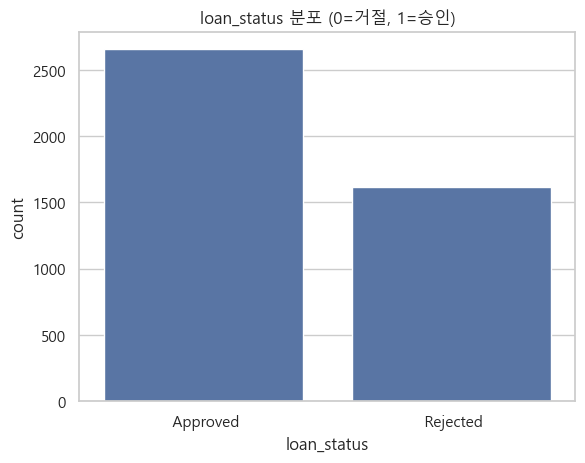

In [3]:
print('데이터 크기:', df.shape)
df.info()
df.head()

print("\nloan_status 분포:")
print(df["loan_status"].value_counts())

sns.countplot(x="loan_status", data=df)
plt.title("loan_status 분포 (0=거절, 1=승인)")
plt.show()


## 2️⃣ 결측치 처리
- 각 컬럼의 결측치 개수를 출력하세요: `df.isnull().sum()`
- 결측치 처리 규칙(학습용 간단 버전):
  - `education`, `self_employed` 처럼 범주형(object)은 최빈값(mode)으로 채운다.
  - 나머지 수치형(int/float)은 중앙값(median)으로 채운다.
- 결측치 처리 후 다시 `isnull().sum()`으로 확인하세요.

In [4]:
print(df.isnull().sum())

loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


In [5]:
cols = df.columns
cols

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

In [15]:
for col in cols:
    print(f"{col:<30} {df[col].nunique()}")

loan_id                        4269
no_of_dependents               6
education                      2
self_employed                  2
income_annum                   98
loan_amount                    378
loan_term                      10
cibil_score                    601
residential_assets_value       278
commercial_assets_value        188
luxury_assets_value            379
bank_asset_value               146
loan_status                    2


In [6]:
df_prep = df.copy()

# 범주형 -> 최빈값 대체
cat_cols = ['education', 'self_employed']
for c in cat_cols:
    if c in df_prep.columns:
        df_prep[c] = df_prep[c].fillna(df_prep[c].mode()[0])

# 수치형 -> 중앙값 대체
num_cols = [col for col in df_prep.columns if col not in cat_cols]
for c in num_cols:
    if df_prep[c].dtype != 'O':
        df_prep[c] = df_prep[c].fillna(df_prep[c].median())

print("\n결측치 처리 후:")
print(df_prep.isnull().sum())
df_prep.head()

loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

결측치 처리 후:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 3️⃣ 범주형 인코딩
- `education`, `self_employed`는 문자열 → 숫자로 변환해야 합니다.
- LabelEncoder를 사용하여 이 두 컬럼을 정수로 바꾸세요.
- 인코딩된 결과를 `df_encoded.head()`로 확인하세요.

In [7]:
df_encoded = df_prep.copy()

encoders = {}
for c in ['education', 'self_employed']:
    le = LabelEncoder()
    df_encoded[c] = le.fit_transform(df_encoded[c])
    encoders[c] = le

df_encoded.head(), df_encoded.dtypes


(   loan_id  no_of_dependents  education  self_employed  income_annum  \
 0        1                 2          0              0       9600000   
 1        2                 0          1              1       4100000   
 2        3                 3          0              0       9100000   
 3        4                 3          0              0       8200000   
 4        5                 5          1              1       9800000   
 
    loan_amount  loan_term  cibil_score  residential_assets_value  \
 0     29900000         12          778                   2400000   
 1     12200000          8          417                   2700000   
 2     29700000         20          506                   7100000   
 3     30700000          8          467                  18200000   
 4     24200000         20          382                  12400000   
 
    commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
 0                 17600000             22700000           8000

## 4️⃣ 학습/테스트 분리
- 설명변수 X는 `loan_status`를 제외한 나머지 컬럼입니다.
- 타깃 y는 `loan_status`입니다.
- `train_test_split`으로 학습 80%, 테스트 20%로 나누세요 (`random_state=42`, `stratify=y`).
- X_train, X_test의 shape를 출력하세요.

In [8]:
X = df_encoded.drop("loan_status", axis=1)
y = df_encoded["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)


X_train shape: (3415, 12)
X_test  shape: (854, 12)


## 5️⃣ 결정트리 학습 및 과적합 확인
- `DecisionTreeClassifier(random_state=42)`로 모델을 학습하세요.
- `DecisionTreeClassifier(max_depth=3, random_state=42)` 모델도 학습하세요.
- 각 모델에 대해 학습 정확도(train acc)와 테스트 정확도(test acc)를 비교하세요.
- 가지치기(max_depth 제한)가 과적합을 줄였는지 해석하세요.

In [9]:
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(X_train, y_train)

tree_limited = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_limited.fit(X_train, y_train)

train_acc_full = accuracy_score(y_train, tree_full.predict(X_train))
test_acc_full  = accuracy_score(y_test,  tree_full.predict(X_test))

train_acc_lim  = accuracy_score(y_train, tree_limited.predict(X_train))
test_acc_lim   = accuracy_score(y_test,  tree_limited.predict(X_test))

print("Full Tree  - train acc:", train_acc_full, " test acc:", test_acc_full)
print("Limited(3) - train acc:", train_acc_lim,  " test acc:", test_acc_lim)


Full Tree  - train acc: 1.0  test acc: 0.9765807962529274
Limited(3) - train acc: 0.9622254758418741  test acc: 0.9718969555035128


## 6️⃣ 결정트리 시각화
- `plot_tree(tree_limited, ...)`로 가지치기된 트리를 시각화하세요.
- `feature_names=X.columns`, `class_names=['Reject','Approve']` 형태로 표시하세요.
- 루트 노드 분기 기준이 되는 변수는 무엇이며, 그게 실제 대출 심사에서 왜 중요할까요?

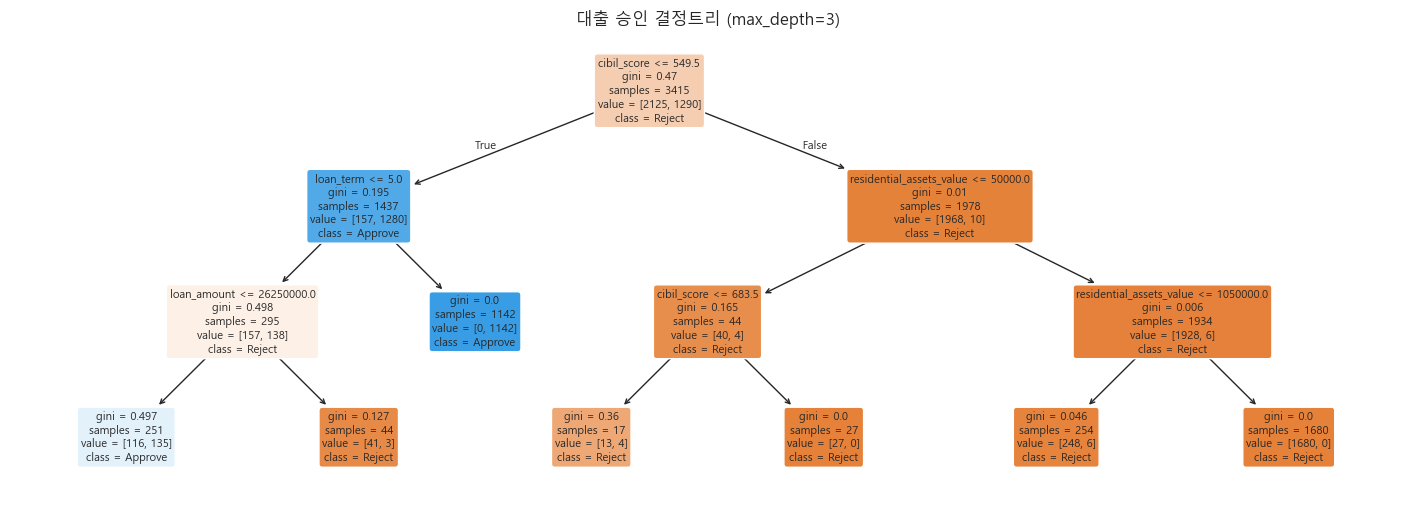

In [10]:
plt.figure(figsize=(18,6))
plot_tree(
    tree_limited,
    feature_names=X.columns,
    class_names=["Reject","Approve"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("대출 승인 결정트리 (max_depth=3)")
plt.show()


## 7️⃣ 모델 평가 (혼동행렬 & 리포트)
- `tree_limited` 모델로 테스트셋을 예측하세요 (y_pred).
- `classification_report`와 `confusion_matrix`를 출력하세요.
- 어떤 오류가 더 치명적인지 설명하세요:
  - 승인해야 할 고객을 거절로 예측한 경우?
  - 거절해야 할 고객을 승인으로 예측한 경우?

분류 리포트:
              precision    recall  f1-score   support

    Approved       0.99      0.96      0.98       531
    Rejected       0.94      0.99      0.96       323

    accuracy                           0.97       854
   macro avg       0.97      0.98      0.97       854
weighted avg       0.97      0.97      0.97       854

혼동 행렬:
 [[510  21]
 [  3 320]]


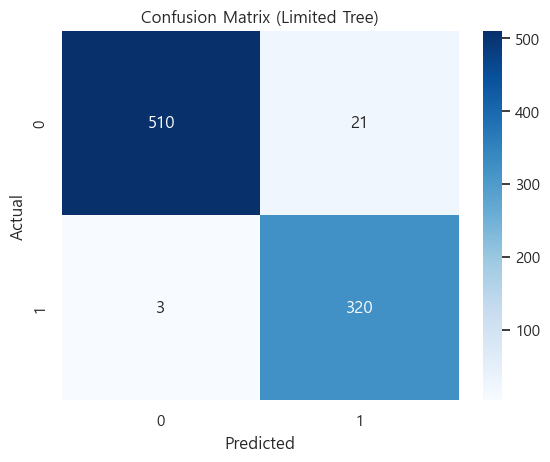

In [11]:
y_pred = tree_limited.predict(X_test)

print("분류 리포트:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("혼동 행렬:\n", cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Limited Tree)")
plt.show()


## 8️⃣ 변수 중요도 (Feature Importance)
- `tree_limited.feature_importances_`를 이용해 변수 중요도를 계산하세요.
- barplot으로 내림차순 시각화하세요.
- 상위 중요한 변수 3개를 골라서, 금융적으로 납득이 되는지 서술하세요
  (예: cibil_score가 높을수록 승인될 가능성이 높다 → 신용점수 중요).

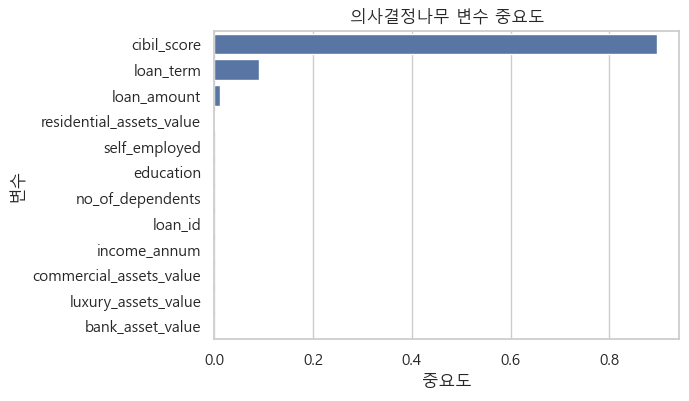

cibil_score                 0.896905
loan_term                   0.091137
loan_amount                 0.011334
residential_assets_value    0.000624
self_employed               0.000000
education                   0.000000
no_of_dependents            0.000000
loan_id                     0.000000
income_annum                0.000000
commercial_assets_value     0.000000
dtype: float64

In [12]:
importances = pd.Series(tree_limited.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("의사결정나무 변수 중요도")
plt.xlabel("중요도")
plt.ylabel("변수")
plt.show()

importances.head(10)


## 9️⃣ 가지치기(Pruning) 실험
- max_depth를 1~6으로 바꿔가며 모델을 학습하세요.
- 각 깊이에 대해 테스트 정확도를 기록하세요.
- (x=깊이, y=정확도) 선 그래프로 시각화하세요.
- 깊이가 커질수록 어떤 패턴(과적합/일반화 변화)이 나타나는지 해석하세요.

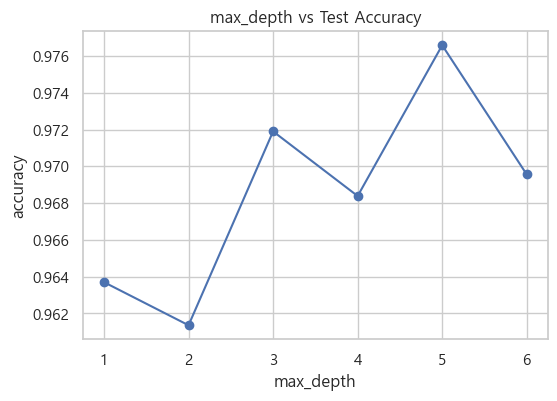

[(1, 0.9637002341920374),
 (2, 0.9613583138173302),
 (3, 0.9718969555035128),
 (4, 0.968384074941452),
 (5, 0.9765807962529274),
 (6, 0.9695550351288056)]

In [13]:
depth_list = []
acc_list = []

for depth in range(1,7):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred_depth = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_depth)
    depth_list.append(depth)
    acc_list.append(acc)

plt.figure(figsize=(6,4))
plt.plot(depth_list, acc_list, marker='o')
plt.title("max_depth vs Test Accuracy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

list(zip(depth_list, acc_list))


## 🔟 비즈니스/핀테크 관점 해석 (서술형)
- 트리의 첫 분기(루트 노드)는 무엇인가요? 이건 어떤 리스크 판단 기준을 시사하나요?
- 잘못 승인(회수 불가능 위험) vs 잘못 거절(매출 기회 상실) 중 어떤 게 금융기관 입장에서 더 치명적인가요?
- 실제 핀테크 심사 서비스에 이 트리를 그대로 쓰려면 어떤 공정성·설명가능성(Explainability) 이슈가 있나요?

### 해설 예시
- 루트 노드가 `cibil_score`라면, 신용 점수가 1차 필터라는 뜻. 이는 실제 금융 심사와 매우 유사합니다.
- '거절해야 할 고객을 승인'하면 부실대출로 직접 손실이 발생하므로 리스크가 매우 큽니다.
- '승인 가능한 고객을 거절'하면 이익 기회를 잃지만 당장 손실은 아니죠.
- 실제 서비스에서는 모델의 거절 사유를 설명해야 하고, 특정 고객군(예: 자영업자)을 체계적으로 불리하게 만들지 않는지 규제 관점에서 검토가 필요합니다.


---
🎉 완료!
이제 금융(대출 승인) 데이터를 이용해 전처리 → 모델 학습 → 평가 → 해석 → 리스크 논의까지 한 번에 경험했습니다.
